In [113]:
import os 
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [114]:
#Leemos las credenciales de acceso a la API de kaggle
os.environ['kaggle_API'] = os.getcwd()

In [115]:
# Descomprimimos el archivo descargado
with zipfile.ZipFile("league-of-legends-worlds-2024-swiss-stage-stats.zip", 'r') as zip_ref:
    zip_ref.extractall()  # Extraemos todos los archivos en el directorio de trabajo actual

In [116]:
#Cargamos el dataset en un Dataframe de Pandasc
df_lol = pd.read_csv('champions.csv')

#Mostramos las primeras filas para confirmar carga de datos en la variable
df_lol.head()

,Champion,Picks,Bans,Presence,Wins,Losses,Winrate,KDA,Avg BT,GT,CSM,DPM,GPM,CSD@15,GD@15,XPD@15
0,Aurora,9,30,100%,7.0,2.0,78%,6.6,3.6,32:52:00,7.9,678.0,402.0,0.6,76.0,-10.0
1,Yone,18,19,95%,13.0,5.0,72%,4.4,3.2,32:14:00,9.6,711.0,451.0,6.7,434.0,372.0
2,Rell,26,5,79%,15.0,11.0,58%,3.0,8.8,34:22:00,1.0,144.0,247.0,-0.5,11.0,-58.0
3,Jax,15,15,77%,6.0,9.0,40%,2.6,5,35:00:00,7.8,403.0,396.0,-8.9,-128.0,-201.0
4,Skarner,13,17,77%,7.0,6.0,54%,3.9,4,31:48:00,5.8,372.0,332.0,2.4,77.0,77.0


In [117]:
#Mostramos información general sobre el dataser
df_lol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Champion  168 non-null    object 
 1   Picks     168 non-null    int64  
 2   Bans      168 non-null    int64  
 3   Presence  168 non-null    object 
 4   Wins      64 non-null     float64
 5   Losses    64 non-null     float64
 6   Winrate   64 non-null     object 
 7   KDA       64 non-null     float64
 8   Avg BT    168 non-null    object 
 9   GT        64 non-null     object 
 10  CSM       64 non-null     float64
 11  DPM       64 non-null     float64
 12  GPM       64 non-null     float64
 13  CSD@15    64 non-null     float64
 14  GD@15     64 non-null     float64
 15  XPD@15    64 non-null     float64
dtypes: float64(9), int64(2), object(5)
memory usage: 21.1+ KB


In [118]:
#Resumen estadístico de las variables numéricas
df_lol.describe()

,Picks,Bans,Wins,Losses,KDA,CSM,DPM,GPM,CSD@15,GD@15,XPD@15
count,168.000000,168.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,2.321429,2.315476,3.046875,3.046875,5.020313,7.078125,516.140625,380.890625,1.453125,85.531250,28.281250
std,4.549556,5.030613,3.470646,2.774199,4.188161,2.694407,227.381357,73.080542,11.518019,568.744732,527.419247
min,0.000000,0.000000,0.000000,0.000000,0.900000,1.000000,114.000000,209.000000,-28.000000,-1259.000000,-1260.000000
25%,0.000000,0.000000,1.000000,1.000000,2.575000,6.175000,368.750000,346.500000,-5.525000,-219.750000,-302.250000
50%,0.000000,0.000000,2.000000,2.500000,3.600000,7.850000,510.000000,389.000000,0.900000,76.000000,2.000000
75%,3.000000,1.000000,4.250000,5.000000,5.975000,8.825000,672.000000,431.000000,5.575000,384.000000,378.750000
max,26.000000,30.000000,15.000000,11.000000,21.000000,10.400000,1063.000000,512.000000,30.000000,1976.000000,1302.000000


In [119]:
#Limpieza de datos para efectividad al momento de realizar el análisis (iniciamos convirtiendo presence y winrate de porcentaje a float)
df_lol['Presence'] = df_lol['Presence'].str.replace('%', '').astype(float)
df_lol['Winrate'] = df_lol['Winrate'].str.replace('%', '').astype(float)

In [120]:
#Llenamos los valores nulos en columnas clave con 0 para normalizar valores (En caso de llegar a necesitar cualquiera para análisis)
df_lol[['Wins','Losses','KDA','CSM','DPM','GPM','CSD@15','GD@15','XPD@15']] = df_lol[['Wins','Losses','KDA','CSM','DPM','GPM','CSD@15','GD@15','XPD@15']].fillna(0)

In [121]:
#Definimos la variable 'Optimo' relacionada al winrate promedio y calculamos el promedio de la tasa de victorias para establecer el umbral
umbral_winrate = df_lol['Winrate'].mean()
df_lol['Optimo'] = df_lol['Winrate'].apply(lambda x: 1 if x >= umbral_winrate else 0)


In [122]:
#Elegimos las características relevants que afectan el rendimiento de cada campeón
características = ['Picks','Bans','Presence', 'KDA','DPM','GPM']
x = df_lol[características]
y = df_lol['Optimo'] #Variable objetivo

In [123]:
#Dividimos el dataset en conjuntos de entrenamiento y prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(x, y, test_size=0.2, random_state=42)

In [124]:
#Entrenamos el modelo para la regresión logística
modelo_logistico = LogisticRegression(max_iter=1000)
modelo_logistico.fit(x_entrenamiento, y_entrenamiento)

LogisticRegression(max_iter=1000)

In [125]:
#Realizamos predicciones y evaluamos el modelo
y_prediccion = modelo_logistico.predict(x_prueba)

In [126]:
#Calculamos precisión, matriz de confusión y reporte de clasificaci+on
precision = accuracy_score(y_prueba, y_prediccion)
matriz_confusion = confusion_matrix(y_prueba, y_prediccion)
reporte_clasificacion = classification_report(y_prueba, y_prediccion)

#Mostramos los resultados 
print("Precisión del Modelo: ", precision)
print("\nMatriz de confusión:\n", matriz_confusion)
print("\nReporte de clasificación:\n", reporte_clasificacion)

Precisión del Modelo:  0.8823529411764706

Matriz de confusión:
 [[26  3]
 [ 1  4]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
           1       0.57      0.80      0.67         5

    accuracy                           0.88        34
   macro avg       0.77      0.85      0.80        34
weighted avg       0.91      0.88      0.89        34



In [127]:
#Realizamos predicciones sobre el conjunto completo de campeones 
df_lol['prediccion_optimo'] = modelo_logistico.predict(x)

In [128]:
# Mostramos el listado de campeones, su tasa de victorias y si serán óptimos o no según el modelo
resultados_optimos = df_lol[['Champion', 'Winrate', 'prediccion_optimo']].copy()
resultados_optimos['prediccion_optimo'] = resultados_optimos['prediccion_optimo'].map({1: 'Óptimo', 0: 'No óptimo'})

#Mostramos el listado
resultados_optimos.head(20)

,Champion,Winrate,prediccion_optimo
0,Aurora,78.0,Óptimo
1,Yone,72.0,Óptimo
2,Rell,58.0,Óptimo
3,Jax,40.0,Óptimo
4,Skarner,54.0,Óptimo
5,Ziggs,40.0,No óptimo
6,Ashe,60.0,Óptimo
7,Gnar,65.0,Óptimo
8,Kaisa,56.0,Óptimo
9,Poppy,22.0,No óptimo


In [129]:
#Graficamos para hacer el análisis más sencillo
sns.set(style="whitegrid")

#Ordenamos los campeones por tasa de victoria para mejorar la visualización
resultados_optimos = resultados_optimos.sort_values(by='Winrate', ascending=False)

#Creamos colores para distinguir entre óptimo y no óptimo
colores = resultados_optimos['prediccion_optimo'].map({'Óptimo': 'green', 'No óptimo': 'red'})

Text(0.5, 1.0, 'Clasificación de Campeones como Óptimos o No Óptimos según el Modelo')

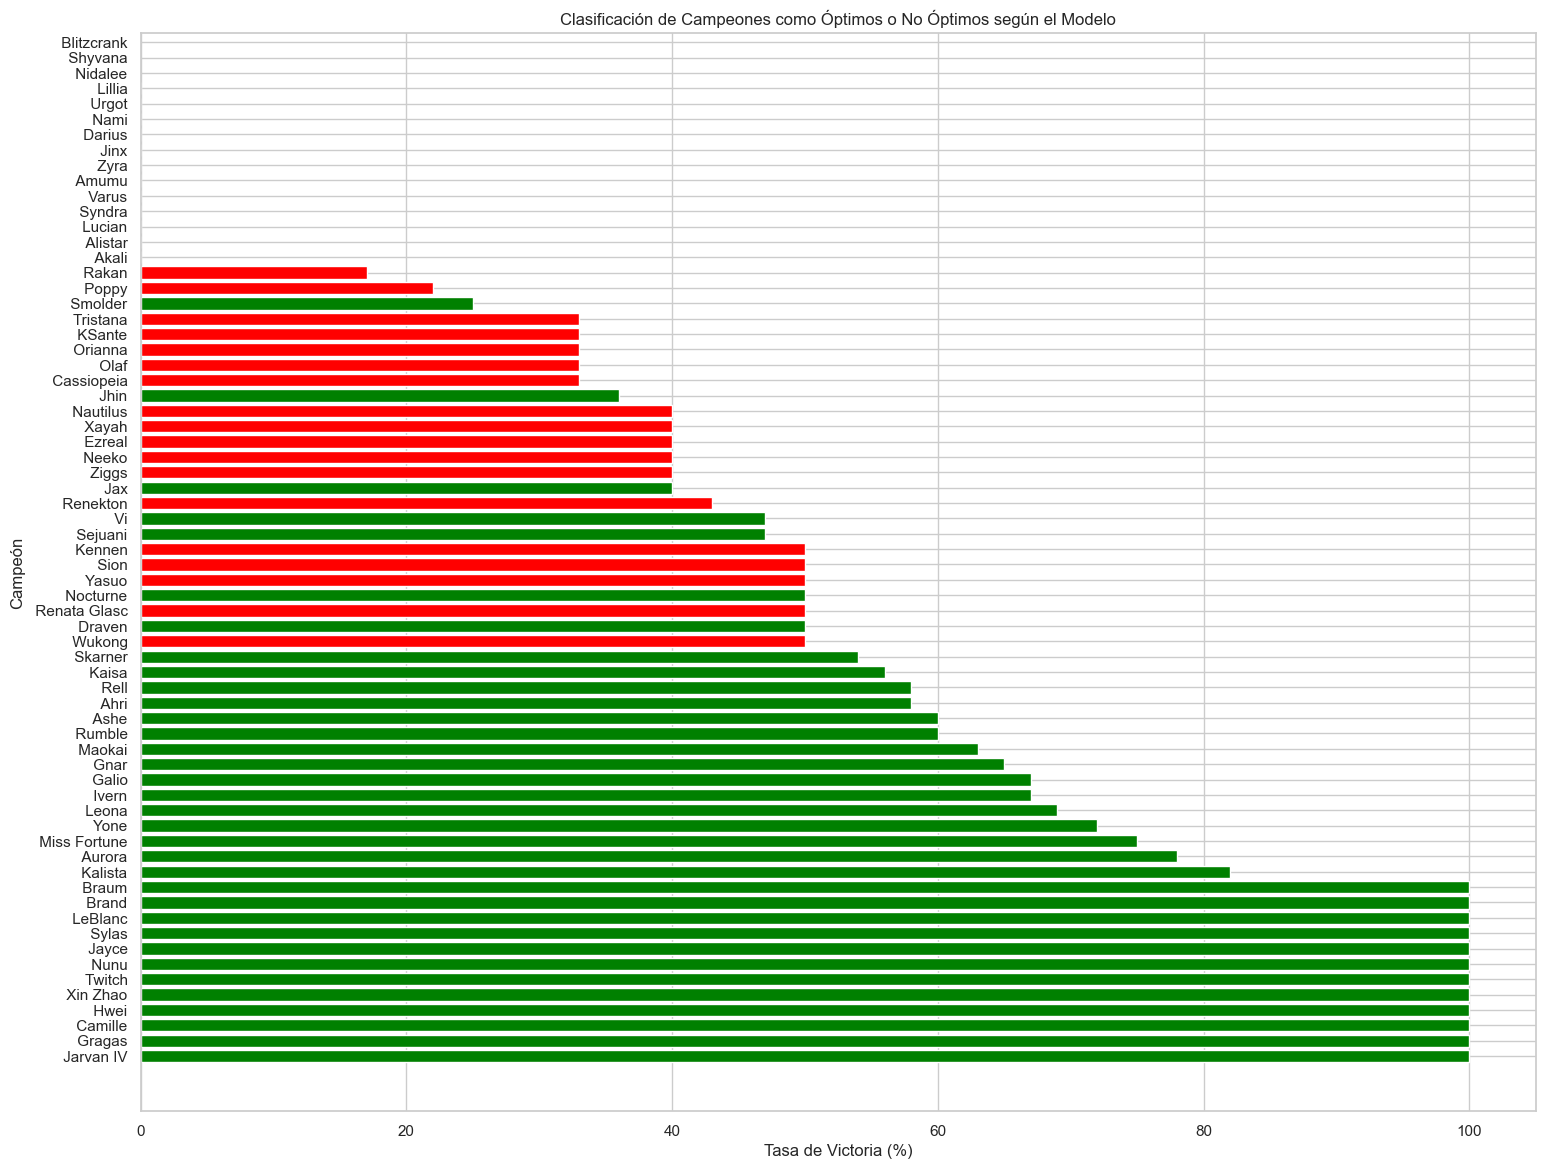

In [130]:
#Creamos el gráfico de barras (Cabe resaltar que los campeones que no tienen una clasificación NO FUERON USADOS DURANTE EL MUNDIAL)
plt.figure(figsize=(18, 14))
plt.barh(resultados_optimos['Champion'], resultados_optimos['Winrate'], color=colores)
plt.xlabel("Tasa de Victoria (%)")
plt.ylabel("Campeón")
plt.title("Clasificación de Campeones como Óptimos o No Óptimos según el Modelo")
